# CHIP 2018

- 数据加载

- 测试集合中的问题id有多少出现在训练集中？

- 字、词序列的长度分布

- 正负样本比例

- 字、词序列最大长度的覆盖率

- 数据扩充

- 使用标签为1的样本来构造图，则任何最小子图里的句子都是同义的

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import queue
from sklearn import utils

In [33]:
def load_data():
    train_data = pd.read_csv('../data/train.csv')
    test_data = pd.read_csv('../data/test.csv')

    questions = pd.read_csv('../data/question_id.csv')

    def get_sequence(df, q='q1', left_id='qid1'):
        tmp = pd.merge(df, questions, left_on=left_id, right_on='qid', how='left')
        df['{}_w'.format(q)] = tmp['wid'].values
        df['{}_c'.format(q)] = tmp['cid'].values

    get_sequence(train_data, q='q1', left_id='qid1')
    get_sequence(test_data, q='q1', left_id='qid1')

    get_sequence(train_data, q='q2', left_id='qid2')
    get_sequence(test_data, q='q2', left_id='qid2')

    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)
    return train_data, test_data

# 加载数据

In [2]:
questions = pd.read_csv('../data/question_id.csv')
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
test_data['label'] = -1

In [3]:
questions.head()

,qid,wid,cid
0,S100000,W106264 W106315 W100323 W100320 W103948 W104806,C100800 C102221 C101975 C100777 C101263 C10101...
1,S100001,W107170 W101597 W101396 W100806 W102193 W106525,C100291 C101643 C100114 C101479 C101848 C10170...
2,S100002,W108463 W103948 W107108 W105043 W109529 W10608...,C100291 C101643 C100114 C100637 C101176 C10135...
3,S100003,W100914 W103546 W106853,C100376 C101061 C101618 C101642 C101318 C10226...
4,S100004,W106711 W106396 W104382 W108553 W102193 W104454,C101977 C100828 C100536 C100076 C100376 C10033...


In [4]:
train_data.head()

,qid1,qid2,label
0,S107641,S103854,0
1,S103127,S110857,1
2,S120534,S135254,1
3,S102044,S106012,0
4,S134333,S109235,0


In [5]:
test_data.head()

,qid1,qid2,label
0,S101364,S126188,-1
1,S132542,S113317,-1
2,S119115,S116093,-1
3,S133446,S131950,-1
4,S115891,S111314,-1


In [6]:
len(questions)

35268

# 测试集合中的问题id有多少出现在训练集中？

结论： 测试中的句子id都没有在训练集中出现过

In [7]:
train_ids = list(train_data['qid1'].values)
train_ids += list(train_data['qid2'].values)
train_ids = list(set(train_ids))
len(train_ids)

21787

In [8]:
test_ids = list(test_data['qid1'].values)
test_ids += list(test_data['qid2'].values)
test_ids = list(set(test_ids))
len(test_ids)

13481

In [9]:
train_ids_df= pd.DataFrame(train_ids, columns=['train_id'])
test_ids_df = pd.DataFrame(test_ids, columns=['test_id'])

tmp = pd.merge(train_ids_df, test_ids_df, left_on='train_id', right_on='test_id', how='inner')
len(tmp)

0

# 长度分布统计

In [10]:
wid_len = []
cid_len = []
for idx in range(len(questions)):
    wid = questions.loc[idx, 'wid'].split()
    cid = questions.loc[idx, 'cid'].split()
    wid_len.append(len(wid))
    cid_len.append(len(cid))

/home/zju/softwares/anaconda3/envs/rllab/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


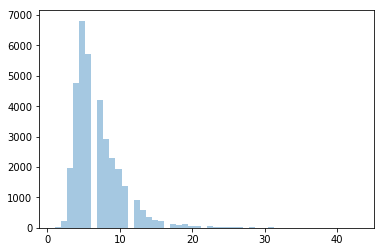

In [11]:
sns.distplot(wid_len, kde=False)

/home/zju/softwares/anaconda3/envs/rllab/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


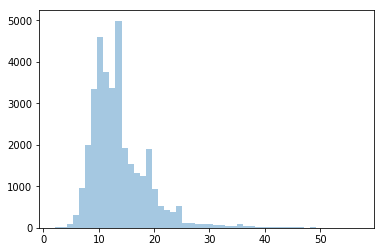

In [12]:
sns.distplot(cid_len, kde=False)

# 正负比例

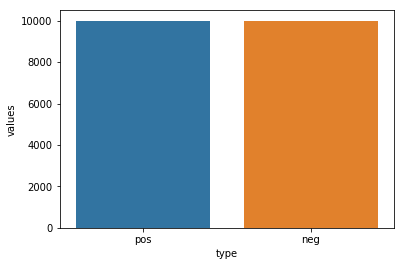

In [13]:
pos = train_data[train_data['label'] == 1]
neg = train_data[train_data['label'] == 0]

fig_data = []
fig_data.append(['pos', len(pos)])
fig_data.append(['neg', len(neg)])
fig_data_df = pd.DataFrame(fig_data, columns=['type', 'values'])
sns.barplot(x=fig_data_df['type'], y=fig_data_df['values'])

# 最大长度覆盖率

In [14]:
wid_len_df = pd.Series(wid_len)
cid_len_df = pd.Series(cid_len)

w_threshold = 15
c_threshold = 25

wid_len_less = wid_len_df[wid_len_df <= w_threshold]
cid_len_less = cid_len_df[cid_len_df <= c_threshold]

print('词小于等于{}的覆盖率：{}'.format(w_threshold, len(wid_len_less) / len(wid_len_df)))
print('字小于等于{}的覆盖率：{}'.format(c_threshold, len(cid_len_less) / len(cid_len_df)))


词小于等于15的覆盖率：0.9731768175116252
字小于等于25的覆盖率：0.9696041737552455


# 数据扩充


扩充规则：

A = B and B != C ==> A != C

A = B and B = C ==> A = C

In [15]:
print('原始qid1数据量：{}'.format(len(train_data['qid1'])))

tmp = train_data['qid1'].drop_duplicates()

print('不重复qid1数据量：{}'.format(len(tmp)))

原始qid1数据量：20000
不重复qid1数据量：14915


In [16]:
print('原始pid2数据量：{}'.format(len(train_data['qid2'])))

tmp = train_data['qid2'].drop_duplicates()

print('不重复qid2数据量：{}'.format(len(tmp)))

原始pid2数据量：20000
不重复qid2数据量：14884


In [17]:
label1 = train_data[train_data['label'] == 1]
label0 = train_data[train_data['label'] == 0]

## 使用A = B and B = C --> A = C 规则进行扩充

### left qid1 == right qid1

In [18]:
# qid1 = qid1
merge_data = pd.merge(label1, label1, left_on='qid1', right_on='qid1', how='outer')
merge_data = merge_data.reset_index(drop=True)

merge1_res1 = merge_data[merge_data['qid2_x'] != merge_data['qid2_y']]
merge1_res1 = merge1_res1.reset_index(drop=True)

merge1_res1 = merge1_res1.drop(['qid1', 'label_x', 'label_y'], axis=1)

merge1_res1['label'] = 1
merge1_res1 = merge1_res1.rename(columns={'qid2_x':'qid1', 'qid2_y': 'qid2'})

print('merge1_res1 data size: {}'.format(len(merge1_res1)))

merge1_res1.head()

merge1_res1 data size: 758


,qid1,qid2,label
0,S100679,S100878,1
1,S100878,S100679,1
2,S108214,S133693,1
3,S133693,S108214,1
4,S108498,S116453,1


### left qid2 == right qid2

In [19]:
# qid2 = qid2
merge_data = pd.merge(label1, label1, left_on='qid2', right_on='qid2', how='inner')
merge_data = merge_data.reset_index(drop=True)

merge1_res2 = merge_data[merge_data['qid1_x'] != merge_data['qid1_y']]
merge1_res2 = merge1_res2.reset_index(drop=True)

merge1_res2 = merge1_res2.drop(['qid2', 'label_x', 'label_y'], axis=1)

merge1_res2['label'] = 1

merge1_res2 = merge1_res2.rename(columns={'qid1_x':'qid1', 'qid1_y':'qid2'})

print('merge1_res2 data size: {}'.format(len(merge1_res2)))

merge1_res2.head()

merge1_res2 data size: 752


,qid1,qid2,label
0,S103127,S103452,1
1,S103452,S103127,1
2,S119992,S132424,1
3,S132424,S119992,1
4,S120784,S117308,1


### left qid1 == right qid2

In [20]:
# qid1 = qid2
merge_data = pd.merge(label1, label1, left_on='qid1', right_on='qid2', how='inner')
merge_data = merge_data.reset_index(drop=True)

merge1_res3 = merge_data[merge_data['qid2_x'] != merge_data['qid1_y']]
merge1_res3 = merge1_res3.reset_index(drop=True)

merge1_res3 = merge1_res3.drop(['label_x', 'label_y', 'qid1_x', 'qid2_y'], axis=1)

merge1_res3['label'] = 1

merge1_res3 = merge1_res3.rename(columns={'qid2_x':'qid1', 'qid1_y':'qid2'})

print('merge1_res3 data size: {}'.format(len(merge1_res3)))

merge1_res3.head()

merge1_res3 data size: 835


,qid1,qid2,label
0,S100458,S100167,1
1,S107405,S113566,1
2,S117947,S126272,1
3,S117074,S104923,1
4,S130624,S104923,1


### left qid2 == right qid1

和上一个内容上是重复的

In [21]:
# qid2 = qid1
# 和上一个重复了

# merge_data = pd.merge(label1, label1, left_on='qid2', right_on='qid1', how='inner')
# merge_data = merge_data.reset_index(drop=True)

# merge1_res4 = merge_data[merge_data['qid1_x'] != merge_data['qid2_y']]
# merge1_res4 = merge1_res4.reset_index(drop=True)

# merge1_res4 = merge1_res4.drop(['qid2_x', 'qid1_y', 'label_x', 'label_y'], axis=1)

# merge1_res4['label'] = 1

# merge1_res4 = merge1_res4.rename(columns={'qid1_x':'qid1','qid2_y':'qid2'})

# print('merge1_res4 data size: {}'.format(len(merge1_res4)))

# merge_res4.head()

### merge all infer label 1 data

In [22]:
infer_label1_data = pd.concat([merge1_res1, merge1_res2, merge1_res3], axis=0)
infer_label1_data = infer_label1_data.reset_index(drop=True)
len(infer_label1_data)
infer_label1_data.to_csv('../data/infer_label1_data.csv', index=False)
print('infer label 1 data size: {}'.format(len(infer_label1_data)))

infer label 1 data size: 2345


## 使用规则 A = B and B != C --> A != C 规则进行扩充

### left qid1 = right qid1

In [23]:
merge_data = pd.merge(label1, label0, left_on='qid1', right_on='qid1', how='inner')
merge0_res1 = merge_data.reset_index(drop=True)
print('merge data size: {}'.format(len(merge0_res1)))

del merge0_res1['qid1']
del merge0_res1['label_x']
del merge0_res1['label_y']

merge0_res1['label'] = 0
merge0_res1 = merge0_res1.rename(columns={'qid2_x':'qid1','qid2_y':'qid2'})
merge0_res1 = merge0_res1.drop_duplicates()

merge0_res1.head()

merge data size: 4293


,qid1,qid2,label
0,S112201,S115851,0
1,S107405,S119124,0
2,S108686,S119308,0
3,S100679,S105351,0
4,S100878,S105351,0


### left qid2 = right qid2

In [24]:
merge_data = pd.merge(label1, label0, left_on='qid2', right_on='qid2', how='inner')
merge_data = merge_data.reset_index(drop=True)

del merge_data['qid2']
del merge_data['label_x']
del merge_data['label_y']

merge0_res2 = merge_data[merge_data['qid1_x'] != merge_data['qid1_y']]
merge0_res2 = merge0_res2.reset_index(drop=True)

merge0_res2 = merge0_res2.rename(columns={'qid1_x':'qid1','qid1_y':'qid2'})
merge0_res2['label'] = 0

print('merge0_res2 data size: {}'.format(len(merge0_res2)))

merge0_res2.head()

merge0_res2 data size: 4325


,qid1,qid2,label
0,S120534,S117778,0
1,S122428,S121421,0
2,S132207,S126475,0
3,S128121,S111459,0
4,S119286,S132385,0


### left qid1 == right qid2

In [25]:
merge_data = pd.merge(label1, label0, left_on='qid1', right_on='qid2', how='inner')
merge_data = merge_data.reset_index(drop=True)

merge0_res3 = merge_data[merge_data['qid2_x'] != merge_data['qid1_y']].reset_index(drop=True)

del merge0_res3['label_x']
del merge0_res3['label_y']
del merge0_res3['qid1_x']
del merge0_res3['qid2_y']

merge0_res3['label'] = 0
merge0_res3 = merge0_res3.rename(columns={'qid2_x':'qid1','qid1_y':'qid2'})

print('merge0_res3 data size: {}'.format(len(merge0_res3)))

merge0_res3.head()

merge0_res3 data size: 4254


,qid1,qid2,label
0,S135254,S135181,0
1,S112201,S123793,0
2,S107405,S100727,0
3,S130447,S120504,0
4,S103402,S103743,0


### left qid2 = right qid1

In [26]:
merge_data = pd.merge(label1, label0, left_on='qid2', right_on='qid1', how='inner')
merge_data = merge_data.reset_index(drop=True)

merge0_res4 = merge_data[merge_data['qid1_x'] != merge_data['qid2_y']].reset_index(drop=True)

merge0_res4 = merge0_res4.drop(['qid2_x', 'qid1_y', 'label_x', 'label_y'], axis=1)

merge0_res4['label'] = 0

merge0_res4 = merge0_res4.rename(columns={'qid1_x':'qid1','qid2_y':'qid2'})

print('merge0_res3 data size: {}'.format(len(merge0_res4)))

merge0_res4.head()

merge0_res3 data size: 4261


,qid1,qid2,label
0,S101149,S115588,0
1,S111502,S126858,0
2,S101883,S121822,0
3,S101883,S110432,0
4,S116478,S102705,0


###  merge all infer label 0 data

In [27]:
infer_label0_data = pd.concat([merge0_res1, merge0_res2, merge0_res3, merge0_res4], axis=0)
infer_label0_data = infer_label0_data.reset_index(drop=True)
infer_label0_data.to_csv('../data/infer_label0_data.csv', index=False)
print('infer_label0_data size: {}'.format(len(infer_label0_data)))
infer_label0_data.head()

infer_label0_data size: 17133


,qid1,qid2,label
0,S112201,S115851,0
1,S107405,S119124,0
2,S108686,S119308,0
3,S100679,S105351,0
4,S100878,S105351,0


# 根据图来生成新的数据

构图使用networkx

使用图来构建数据得到的数据总量约为：53000.

使用新增的数据集来训练，效果差了不少

In [28]:
import networkx as nx

In [29]:
# 构建图
g = nx.Graph()
for idx in range(len(train_data)):
    q1 = train_data.loc[idx, 'qid1']
    q2 = train_data.loc[idx, 'qid2']
    g.add_node(q1)
    g.add_node(q2)
    g.add_edge(q1, q2)
    g[q1][q2]['label'] = train_data.loc[idx, 'label']

In [30]:
# 根据图生成数据
new_data_set = []
cnt = 0
result = []
for n in list(g.nodes()):
    neighbors = list(g.neighbors(n))
    if len(neighbors) == 1:
        new_data_set.append([n, neighbors[0], g[n][neighbors[0]]['label']])
    else:
        pos_n = []
        neg_n = [node for node in neighbors if g[n][node]['label'] == 0 ]
        q = queue.Queue()
        q.put(n)
        vist = {}        
        while q.qsize() > 0:
            t = q.get()
            vist[t] = 1
            pos_n.append(t)
            neighbors = list(g.neighbors(t))
            for node in neighbors:
                if g[t][node]['label'] == 1 and node not in vist:
                    q.put(node)
        # 任意一正一负节点组成负样本
        for pos in pos_n:
            for neg in neg_n:
                if pos < neg:
                    new_data_set.append([pos, neg, 0])
                else:
                    new_data_set.append([neg, pos, 0])
        # 任意两个正节点组成一个正样本
        for idx in range(len(pos_n)):
            for j in range(idx+1, len(pos_n)):
                if pos_n[idx] < pos_n[j]:
                    new_data_set.append([pos_n[idx], pos_n[j], 1])
                else:
                    new_data_set.append([pos_n[j], pos_n[idx], 1])
len(new_data_set)

203875

In [31]:
# 去重
new_data = pd.DataFrame(new_data_set, columns=['qid1', 'qid2', 'label'])
new_data = new_data.drop_duplicates()
new_data = utils.shuffle(new_data)
new_data = utils.shuffle(new_data)
new_data = utils.shuffle(new_data)
new_data = utils.shuffle(new_data)
new_data = new_data.reset_index(drop=True)

print('Total data size : {}'.format(len(new_data)))
print('Postive data size : {}'.format(new_data['label'].sum()))
print('Negtive data size : {}'.format(len(new_data) - new_data['label'].sum()))

Total data size : 53555
Postive data size : 17320
Negtive data size : 36235


In [32]:
# 保存 至本地
new_data.to_csv('your file name', index=False)

# 建立词图

## 词对统计

In [76]:
g = nx.Graph()

train_df, test_df = load_data()

w_list = []

q1s = list(train_df['q1_w'].values)
q2s = list(train_df['q2_w'].values)

for q in q1s:
    w_list += q.split()

for  q in q2s:
    w_list += q.split()

g.add_nodes_from(w_list)

for idx in range(len(train_df)):
    q1 = train_df.loc[idx, 'q1_w'].split()
    q2 = train_df.loc[idx, 'q2_w'].split()
    label = train_df.loc[idx, 'label']
    for w1 in q1:
        for w2 in q2:
            if w1 != w2:
                g.add_edge(w1,w2)
                if label in g[w1][w2]:
                    g[w1][w2][label] += 1
                else:
                    g[w1][w2][label] = 1

In [78]:
def get_label_count(row, g):
    q1 = row['q1_w'].split()
    q2 = row['q2_w'].split()
    label_cnt = {}
    label_cnt[0] = 0
    label_cnt[1] = 0
    for w1 in q1:
        for w2 in q2:
            try:
                edge = g[w1][w2]
                label_cnt[0] += edge[0]
                label_cnt[1] += edge[1]
            except:
                continue
    return '{}:{}'.format(label_cnt[0], label_cnt[1])

In [79]:
train_df['label_cnt'] = train_df.apply(lambda x: get_label_count(x, g), axis=1)

In [80]:
train_df.head()

,qid1,qid2,label,q1_w,q1_c,q2_w,q2_c,label_cnt
0,S107641,S103854,0,W105587 W101644 W102193 W106548 W104416,C101295 C101168 C100955 C101340 C102226 C10088...,W105587 W101644 W102193 W104454,C101295 C101168 C100955 C101340 C102226 C10120...,1438:1670
1,S103127,S110857,1,W106907 W107170 W100323 W101855 W104806,C101836 C102106 C100291 C101643 C100114 C10126...,W108463 W103461 W100735 W103461,C100291 C101643 C100114 C100637 C100099 C10061...,822:1160
2,S120534,S135254,1,W108463 W108376 W101396 W107941 W104416 W106503,C100291 C101643 C100114 C100637 C101585 C10120...,W102817 W103791 W107170 W103190 W104668 W10560...,C102244 C100269 C101836 C101968 C100291 C10164...,14185:14576
3,S102044,S106012,0,W100914 W102600 W104740 W106503 W102627 W10052...,C100376 C101061 C101618 C100376 C101061 C10001...,W100914 W108376 W101478 W100533 W109637 W10480...,C100376 C101061 C101618 C101585 C101200 C10161...,7511:7182
4,S134333,S109235,0,W107170 W102193 W102254 W109339 W101995 W104416,C100291 C101643 C100114 C102226 C101449 C10059...,W107170 W102193 W102254 W109474 W106089 W10441...,C100291 C101643 C100114 C102226 C101449 C10059...,9890:10263


In [64]:
g = nx.Graph()
g.add_nodes_from([1,0,2,3,4,5])
g.add_edge(1,2)

In [70]:
g[1][2][1] = 2

In [71]:
g[1][2]

{1: 2}

In [72]:
g.add_edge(1,2)

In [73]:
g[1][2]

{1: 2}

In [75]:
0 in g[1][2]

False

In [83]:
train_feature = pd.read_csv('../feature/train_feature.csv')
print(len(train_feature.columns))
print(train_feature.columns)

48
Index(['simhash_w1gram_dist', 'simhash_w2gram_dist', 'simhash_w3gram_dist',
       'simhash_c1gram_dist', 'simhash_c2gram_dist', 'simhash_c3gram_dist',
       'len_word_max', 'len_word_min', 'len_char_max', 'len_char_min',
       'word_length_diff', 'char_length_diff', 'cosine_sim', 'manhattan_dis',
       'eucledian_dis', 'jaccard_dis', 'minkowsk_dis', 'w_wmd', 'c_wmd',
       'tfidf_cs', 'tfidf_ed', 'tfidf_md', 'svd_cs', 'svd_ed', 'svd_md',
       'lda_cs', 'lda_ed', 'lda_md', 'w_intersection', 'c_intersection',
       'word_match_share', 'char_match_share', 'tfidf_word_match_share',
       'tfidf_char_match_share', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio_char',
       'token_sort_ratio_char', 'fuzz_ratio_char', 'fuzz_partial_ratio_char',
       'q1_degree', 'q2_degree', 'edit_dist_word', 'edit_dist_char', 'q1_freq',
       'q2_freq'],
      dtype='object')


In [84]:
train_feature = pd.read_csv('../feature/train_feature_with_bm25.csv')
print(len(train_feature.columns))
print(train_feature.columns)

51
Index(['simhash_w1gram_dist', 'simhash_w2gram_dist', 'simhash_w3gram_dist',
       'simhash_c1gram_dist', 'simhash_c2gram_dist', 'simhash_c3gram_dist',
       'len_word_max', 'len_word_min', 'len_char_max', 'len_char_min',
       'word_length_diff', 'char_length_diff', 'cosine_sim', 'manhattan_dis',
       'eucledian_dis', 'jaccard_dis', 'minkowsk_dis', 'w_wmd', 'c_wmd',
       'tfidf_cs', 'tfidf_ed', 'tfidf_md', 'svd_cs', 'svd_ed', 'svd_md',
       'lda_cs', 'lda_ed', 'lda_md', 'w_intersection', 'c_intersection',
       'word_match_share', 'char_match_share', 'tfidf_word_match_share',
       'tfidf_char_match_share', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio_char',
       'token_sort_ratio_char', 'fuzz_ratio_char', 'fuzz_partial_ratio_char',
       'q1_degree', 'q2_degree', 'edit_dist_word', 'edit_dist_char', 'bm25_cs',
       'bm25_ed', 'bm25_md', 'q1_freq', 'q2_freq'],
      dtype='object')


In [91]:
train_feature = pd.read_csv('../feature/train_feature_with_bm25.csv')
test_feature = pd.read_csv('../feature/test_feature_with_bm25.csv')

In [89]:
train_label_cnt = pd.read_csv('../feature/train_feature_wp.csv')
test_label_cnt = pd.read_csv('../feature/test_feature_wp.csv')
train_label_cnt = train_label_cnt[['label_cnt_0', 'label_cnt_1']]
test_label_cnt = test_label_cnt[['label_cnt_0', 'label_cnt_1']]

In [92]:
train_feature = pd.concat([train_feature, train_label_cnt], axis=1)
test_feature = pd.concat([test_feature, test_label_cnt], axis=1)

In [93]:
print(len(train_feature.columns))
print(train_feature.columns)

53
Index(['simhash_w1gram_dist', 'simhash_w2gram_dist', 'simhash_w3gram_dist',
       'simhash_c1gram_dist', 'simhash_c2gram_dist', 'simhash_c3gram_dist',
       'len_word_max', 'len_word_min', 'len_char_max', 'len_char_min',
       'word_length_diff', 'char_length_diff', 'cosine_sim', 'manhattan_dis',
       'eucledian_dis', 'jaccard_dis', 'minkowsk_dis', 'w_wmd', 'c_wmd',
       'tfidf_cs', 'tfidf_ed', 'tfidf_md', 'svd_cs', 'svd_ed', 'svd_md',
       'lda_cs', 'lda_ed', 'lda_md', 'w_intersection', 'c_intersection',
       'word_match_share', 'char_match_share', 'tfidf_word_match_share',
       'tfidf_char_match_share', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio_char',
       'token_sort_ratio_char', 'fuzz_ratio_char', 'fuzz_partial_ratio_char',
       'q1_degree', 'q2_degree', 'edit_dist_word', 'edit_dist_char', 'bm25_cs',
       'bm25_ed', 'bm25_md', 'q1_freq', 'q2_freq', 'label_cnt_0',
       'label_cnt_1'],
      dtype='objec

In [94]:
train_feature.to_csv('../feature/train_feature_53.csv', index=False)
test_feature.to_csv('../feature/test_feature_53.csv', index=False)

In [95]:
len(train_feature)

20000

In [96]:
len(test_feature)

10000

In [98]:
tmp = np.load('../prediction/dcnn_char_gl_feature/round_1_train_kf_1.npy')

In [99]:
tmp.shape

(4000, 1)